In [ ]:
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

img_path = fnames[3]    # 증식할 이미지를 선택

img = image.load_img(img_path, target_size=(150, 150))    # 이미지를 읽고 크기 변경

x = image.img_to_array(img)    # (150, 150, 3) 크기의 넘파이 배열로 변환
x = x.reshape((1,) + x.shape)    # (1, 150, 150, 3) 크기로 변환
    # flow() 메서드가 배치 데이터를 기대하기 때문에 샘플 데이터에 배치 차원을 추가하여 4D 텐서로 만든다.

# 랜덤하게 변환된 이미지를 생성
# 무한반복 되기 때문에 어느 시점에서 중지해야 한다.
i = 0
for batch in datagen.flow(x, batch_size=1):
	plt.figure(i)
	imgplot = plt.imshow(image.array_to_img(batch[0]))
	i += 1
	if i % 4 == 0:
		break

plt.show()

In [ ]:
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),   # 이 부분이 atrous 확장을 관리하는 부분이다.
	  ...
)

# DeepLabV3+ 분석

from https://github.com/bonlime/keras-deeplab-v3-plus 

## 사전과정

### `extract_weights.py`

In [1]:
from __future__ import print_function

import os
import numpy as np
import tensorflow as tf
from keras.utils.data_utils import get_file


def get_xception_filename(key):
    """Rename tensor name to the corresponding Keras layer weight name.
    # Arguments
        key: tensor name in TF (determined by tf.variable_scope)
    """
    filename = str(key)
    filename = filename.replace('/', '_')
    filename = filename.replace('xception_65_', '')
    filename = filename.replace('decoder_', '', 1)
    filename = filename.replace('BatchNorm', 'BN')
    if 'Momentum' in filename:
        return None
    if 'entry_flow' in filename or 'exit_flow' in filename:
        filename = filename.replace('_unit_1_xception_module', '')
    elif 'middle_flow' in filename:
        filename = filename.replace('_block1', '')
        filename = filename.replace('_xception_module', '')

    # from TF to Keras naming
    filename = filename.replace('_weights', '_kernel')
    filename = filename.replace('_biases', '_bias')

    return filename + '.npy'


def get_mobilenetv2_filename(key):
    """Rename tensor name to the corresponding Keras layer weight name.
    # Arguments
        key: tensor name in TF (determined by tf.variable_scope)
    """
    filename = str(key)
    filename = filename.replace('/', '_')
    filename = filename.replace('MobilenetV2_', '')
    filename = filename.replace('BatchNorm', 'BN')
    if 'Momentum' in filename:
        return None

    # from TF to Keras naming
    filename = filename.replace('_weights', '_kernel')
    filename = filename.replace('_biases', '_bias')

    return filename + '.npy'


def extract_tensors_from_checkpoint_file(filename, output_folder='weights', net_name=None):
    """Extract tensors from a TF checkpoint file.
    # Arguments
        filename: TF checkpoint file
        output_folder: where to save the output numpy array files
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # reader = tf.train.NewCheckpointReader(filename)
    reader = tf.train.load_checkpoint(filename)

    for key in reader.get_variable_to_shape_map():
        # convert tensor name into the corresponding Keras layer weight name and save
        if net_name == 'xception':
            filename = get_xception_filename(key)
        elif net_name == 'mobilenetv2':
            filename = get_mobilenetv2_filename(key)
        if filename:
            path = os.path.join(output_folder, filename)
            arr = reader.get_tensor(key)
            np.save(path, arr)
            print("tensor_name: ", key)

CKPT_URL = 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz'
CKPT_URL_MOBILE = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz'
MODEL_DIR = 'models'
MODEL_SUBDIR = 'deeplabv3_pascal_trainval'
MODEL_SUBDIR_MOBILE = 'deeplabv3_mnv2_pascal_trainval'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

checkpoint_tar = get_file(
    'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    CKPT_URL,
    extract=True,
    cache_subdir='',
    cache_dir=MODEL_DIR)

checkpoint_tar_mobile = get_file(
    'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    CKPT_URL_MOBILE,
    extract=True,
    cache_subdir='',
    cache_dir=MODEL_DIR)

checkpoint_file = os.path.join(MODEL_DIR, MODEL_SUBDIR, 'model.ckpt')
extract_tensors_from_checkpoint_file(
    checkpoint_file, net_name='xception', output_folder='weights/xception')

checkpoint_file = os.path.join(
    MODEL_DIR, MODEL_SUBDIR_MOBILE, 'model.ckpt-30000')
extract_tensors_from_checkpoint_file(
    checkpoint_file, net_name='mobilenetv2', output_folder='weights/mobilenetv2')

23920640/23916119 [==============================] - 0s 0us/step
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_pointwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_pointwise/BatchNorm/beta
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/depthwise_weights
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/BatchNorm/moving_mean
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv3_depthwise/BatchNorm/beta
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv2_pointwise/BatchNorm/moving_variance
tensor_name:  xception_65/middle_flow/block1/unit_9/xception_module/separable_conv2_depthwise/BatchNorm/moving_variance
tensor_na

## 준비

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


In [3]:
def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """짝수 커널 크기에 대해 올바른 'same' 패딩 구현
       이것이 없으면, stride = 2일 때, 1픽셀 드리프트가 있습니다.

        Args:
            x: 입력 텐서
            filters: pointwise 컨볼루션의 필터 수
            prefix: name 앞에 접두사
            stride: depthwise 컨볼루션의 stride
            kernel_size: depthwise 컨볼루션의 커널 크기
            rate: depthwise 컨볼루션에 대한 atrous rate
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', 
                      use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        # 패딩에 대한 설정
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', 
                      use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)

In [4]:
def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ depthwise & pointwise 사이에 BN이 있는 SepConv. 선택적으로 BN 후 활성화 함수를 추가합니다.
        짝수 커널 크기에 대해 올바른 "same" 패딩 구현
        Args:
            x: 입력 텐서
            filters: pointwise 컨볼루션의 필터 수
            prefix: name 앞에 접두사
            stride: depthwise conv에서 stride
            kernel_size: depthwise 컨볼루션에 대한 kernel size
            rate: depthwise 컨볼루션에 대한 atrous rate
            depth_activation: depthwise 및 pointwise convs 간에 활성화 함수를 사용하는 플래그
            epsilon: BN 레이어에서 사용할 epsilon
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)

    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x

def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ 수정된 Xception 네트워크의 기본 빌딩 블록
        Args:
            inputs: 입력 텐서
            depth_list: 각 SepConv 레이어의 필터 수. len(depth_list) == 3
            prefix: name 앞에 접두사
            skip_connection_type: {'conv', 'sum', 'none'} 중 하나
            stride: 마지막 depthwise conv에서 stride
            rate: depthwise 컨볼루션에 대한 atrous rate
            depth_activation: depthwise 및 pointwise convs 간에 활성화 함수를 사용하는 플래그
            return_skip: 디코더를 위해 2 SepConvs 후에 추가 텐서를 반환하는 플래그
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, 
                                depth_list[-1], 
                                prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs

In [5]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # 내림(round down)이 10% 이상 내려 가지 않도록 하십시오.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    # in_channels = inputs.shape[-1].value  # inputs._keras_shape[-1]
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand
        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x

## Deeplabv3+

In [6]:
def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """Deeplabv3+ 아키텍처 인스턴스화
    선택적으로 PASCAL VOC 또는 Cityscapes에 대해 사전 트레이닝된 가중치를 로드합니다.
    이 모델은 TensorFlow에서만 사용할 수 있습니다.

    # Arguments
        weights: 'pascal_voc'(파스칼 voc에 대해 사전 트레이닝 됨), 
           'cityscapes'(cityscape에 대해 사전 트레이닝 됨) 또는 None (랜덤 초기화) 중 하나
        input_tensor: optional. 모델의 이미지 입력으로 사용할 Keras 텐서. (즉, `layers.Input()`의 출력)
        input_shape: 입력 이미지의 shape. HxWxC 형태.
            PASCAL VOC 모델은 (512,512,3) 이미지에 대해 트레이닝 되었습니다. None은 shape/width로 허용됩니다.
        classes: 원하는 클래스 수. PASCAL VOC에는 21개의 클래스가 있으며, Cityscapes에는 19개의 클래스가 있습니다.
            사용된 가중치에 맞지 않는 클래스 수의 경우, 마지막 레이어는 무작위로 초기화됩니다.
        backbone: 사용할 백본. {'xception','mobilenetv2'} 중 하나
        activation: optional 네트워크 상단에 추가할 활성화 함수.
            'softmax', 'sigmoid' 또는 None 중 하나
        OS: input_shape/feature_extractor_output 비율을 결정. {8,16} 중 하나.
            xception 백본에만 사용됩니다.
        alpha: MobileNetV2 네트워크의 width를 제어합니다. 이것은 MobileNetV2 논문에서 width multiplier로 알려져 있습니다.
                - `alpha` < 1.0 이면, 각 레이어의 필터 수를 비례적으로 줄입니다.        
                - `alpha` > 1.0 이면, 각 레이어의 필터 수를 비례적으로 증가합니다.        
                - `alpha` = 1 이면, 각 레이어에서 사용되는 기본 필터 수 입니다.
            mobilenetv2 백본에만 사용됩니다. 사전 트레이닝은 alpha=1에만 사용할 수 있습니다.
    # Returns
        케라스 모델 인스턴스
    # Raises
        RuntimeError: separable 컨볼루션을 지원하지 않는 백엔드로 이 모델을 실행하려는 경우.
        ValueError: `weights` 또는 `backbone`에 대한 잘못된 인수의 경우.
    """

    # `weights` 가중치 파라미터 점검
    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    # `backbone` 파라미터 점검
    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    # 입력 텐서로 입력 설정
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    # 인코더 ==>
    # `xception` 백본의 경우,
    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! 논문에는 언급되지 않았지만, 필요하다.
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        # Entry Flow ===>
        # 32, 3x3, stride 2의 Conv 2D
        x = Conv2D(32, 
                   (3, 3), 
                   strides=(2, 2),
                   name='entry_flow_conv1_1', 
                   use_bias=False, 
                   padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        # 64, 3x3, Conv 2D
        x = _conv2d_same(x, 
                         64, 
                         'entry_flow_conv1_2', 
                         kernel_size=3, 
                         stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        # xception block
        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        # xception block
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)
        # xception block
        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        
        # Middle Flow ===>
        # 16회 반복
        for i in range(16):
            # xception block
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        # Exit Flow ===>
        # xception block
        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        # xception block (without skip)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    # `mobilenetv2` 백본의 경우,
    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)

        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # <== 특성 추출

    # Atrous Spatial Pyramid Pooling에 대한 브랜치
    # 이미지 특성 브랜치
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)

    # upsample. align_corners 옵션 때문에 compat를 사용해야 합니다.
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(
        x, 
        size_before[1:3],
        method='bilinear', 
        align_corners=True))(b4)

    # simple 1x1 Conv
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # [Concat] + 1x1 Conv
    # mobilenetV2에는 2개의 브랜치만 있습니다. 이유를 모르겠다.
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP 브랜치 & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    # Concat + [1x1 Conv]
    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)

    x = Dropout(0.1)(x)
    # <== 인코더
    
    # 디코더 ==>
    if backbone == 'xception':
        # 특성 projection
        # x4 (x2) 블록
        skip_size = tf.keras.backend.int_shape(skip1)
        x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                        skip_size[1:3],
                                                        method='bilinear', align_corners=True))(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # 임의의 수의 클래스와 함께 사용할 수 있습니다.
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    # 이 소스코드에서는 그림의 3x3 Conv와 달리, 1x1 Conv를 사용합니다.
    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                    size_before3[1:3],
                                                    method='bilinear', align_corners=True))(x)

    # 모델이 `input_tensor`의 잠재적 predecessors를 고려하는지 확인합니다.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # 마지막 활성화
    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    # 모델
    model = Model(inputs, x, name='deeplabv3plus')

    # 가중치 불러오기
    if weights == 'pascal_voc':
        if backbone == 'xception':
            print("pascal xception")
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            print("pascal mnv2")
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    
    # 모델 리턴
    return model

## `load_weights.py`

In [7]:
from __future__ import print_function

import os
import numpy as np
from tqdm import tqdm

MODEL_DIR = 'models'

for_data = ('pascal_voc', 21)
# for_data = ('cityscapes', 19)
# for_data = (None, 21)

for backbone in ['mobilenetv2', 'xception']:
    print('Instantiating an empty Deeplabv3+ model...')
    model = Deeplabv3(input_shape=(512, 512, 3), classes=for_data[1], backbone=backbone, weights=for_data[0])

    WEIGHTS_DIR = 'weights/' + backbone
    print('Loading weights from', WEIGHTS_DIR)
    for layer in tqdm(model.layers):
        if layer.weights:
            weights = []
            for w in layer.weights:
                weight_name = os.path.basename(w.name).replace(':0', '')
                weight_file = layer.name + '_' + weight_name + '.npy'
                weight_arr = np.load(os.path.join(WEIGHTS_DIR, weight_file))
                weights.append(weight_arr)
            layer.set_weights(weights)

    print('Saving model weights...')
    OUTPUT_WEIGHT_FILENAME = 'deeplabv3_' + \
        backbone + '_tf_dim_ordering_tf_kernels.h5'
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    f_path = os.path.join(MODEL_DIR, OUTPUT_WEIGHT_FILENAME)
    model.save_weights(f_path)
    print('Model weights at: {}'.format(f_path))

Instantiating an empty Deeplabv3+ model...
pascal mnv2
8986624/8986568 [==============================] - 2s 0us/step


 41%|████▏     | 68/164 [00:00<00:00, 672.78it/s]

Loading weights from weights/mobilenetv2


100%|██████████| 164/164 [00:00<00:00, 689.27it/s]


Saving model weights...
Model weights at: models/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5
Instantiating an empty Deeplabv3+ model...
pascal xception
166100992/166096424 [==============================] - 11s 0us/step


 17%|█▋        | 70/411 [00:00<00:00, 685.41it/s]

Loading weights from weights/xception


100%|██████████| 411/411 [00:00<00:00, 606.25it/s]


Saving model weights...
Model weights at: models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5


# 예측

In [8]:
!mkdir imgs
!wget https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/imgs/image1.jpg?raw=true -O imgs/image1.jpg
!wget https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/imgs/image2.jpg?raw=true -O imgs/image2.jpg
!wget https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/imgs/image3.jpg?raw=true -O imgs/image3.jpg

--2020-09-10 12:09:28--  https://github.com/bonlime/keras-deeplab-v3-plus/blob/master/imgs/image1.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/bonlime/keras-deeplab-v3-plus/raw/master/imgs/image1.jpg [following]
--2020-09-10 12:09:29--  https://github.com/bonlime/keras-deeplab-v3-plus/raw/master/imgs/image1.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bonlime/keras-deeplab-v3-plus/master/imgs/image1.jpg [following]
--2020-09-10 12:09:29--  https://raw.githubusercontent.com/bonlime/keras-deeplab-v3-plus/master/imgs/image1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:

pascal xception


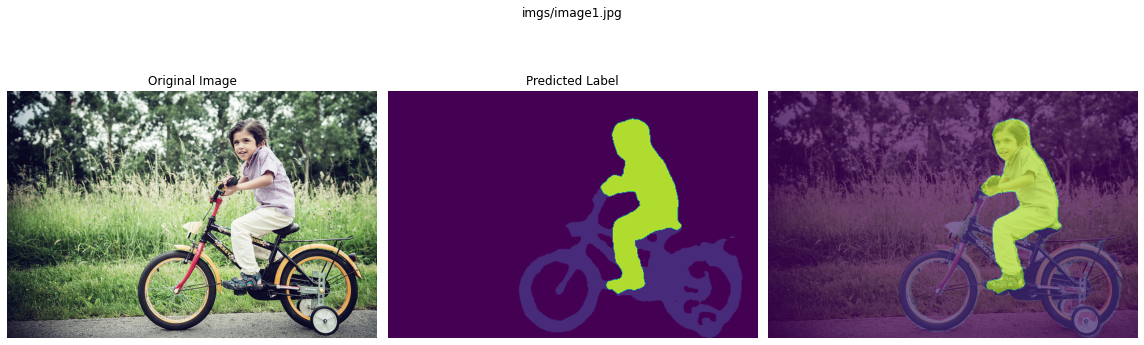

In [14]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from keras.models import load_model

# 가장 기본적인 설정을 사용하여 라벨을 생성합니다.  
# 다양한 이미지 크기를 지원합니다.
# 원본 이미지와 동일한 형식으로 이미지 레이블을 반환합니다. 
# 정규화는 MobileNetV2와 일치합니다.

trained_image_width=512 
mean_subtraction_value=127.5
img_name = 'imgs/image1.jpg'
image = np.array(Image.open('imgs/image1.jpg'))

# 트레이닝 데이터 세트로부터 이미지의 최대 크기로 크기 조정
w, h, _ = image.shape
ratio = float(trained_image_width) / np.max([w, h])
resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))
display_resized_image = resized_image

# 트레이닝된 데이터 세트 이미지에 정규화 적용
resized_image = (resized_image / mean_subtraction_value) - 1.

# 트레이닝 이미지와 일치하도록 배열을 정사각형 이미지로 패딩을 채웁니다.
pad_x = int(trained_image_width - resized_image.shape[0])
pad_y = int(trained_image_width - resized_image.shape[1])
resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

# 예측을 합니다.
configs = [("mobilenetv2", 8, None), ("mobilenetv2", 8, "softmax"), ("mobilenetv2", 8, "sigmoid"),
      ("mobilenetv2", 16, None), ("mobilenetv2", 16, "softmax"), ("mobilenetv2", 16, "sigmoid"),
      ("xception", 8, None), ("xception", 8, "softmax"), ("xception", 8, "sigmoid"),
      ("xception", 16, None), ("xception", 16, "softmax"), ("xception", 16, "sigmoid")]
config = configs[6]
deeplab_model = Deeplabv3(backbone=config[0], OS=config[1], activation=config[2])
# print(deeplab_model.summary())
# deeplab_model = Deeplabv3(backbone="xception")
res = deeplab_model.predict(np.expand_dims(resized_image, 0))
labels = np.argmax(res.squeeze(), -1)

# 패딩을 제거하고 원본 이미지로 다시 크기 조정합니다.
if pad_x > 0:
    labels = labels[:-pad_x]
if pad_y > 0:
    labels = labels[:, :-pad_y]
labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))

f, axarr = plt.subplots(1, 3, figsize=(16, 6))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(image)
axarr[0].set_title('Original Image')
axarr[1].imshow(labels)
axarr[1].set_title('Predicted Label')
axarr[2].imshow(image)
axarr[2].imshow(labels, alpha=0.7)

f.suptitle(img_name)
f.tight_layout()